# Tensorflow tutorial

Contents:
- Building a computational graph and running a session
- visualising the graph with tensorboard
- Training parameters: regression and classifications
- Tensorflow debug

## Building a computational graph

Tensorflow programmes involve building a computational graph `tf.Graph` and running this graph using a `tf.Session`

This graph is composed of:
- `tf.Operation`: The nodes of the graph, that describe calcuations
- `tf.Tensor`: The edges of the graph, representing the values that are input and output to the computations.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# For representing tensor values, tensorflow uses numpy arrays

In [3]:
a = tf.constant(4, dtype=tf.float32)
b = tf.constant(6.0)
b.dtype

tf.float32

In [4]:
a_plus_b = a + b

In [5]:
print(a)
print(b)
print(a_plus_b)

Tensor("Const:0", shape=(), dtype=float32)
Tensor("Const_1:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


printing these tensors doesn't output the values. The only thing we did so far was build the computational graph, where "addition" was the computation. 

Each operation in the graph is given a name (independent of the name of the object you give in python). Here, the output tensor of the addition operation is named after the operation that produced it: `add:0`

## Running a session
To get the actual output values of our computation, we need to create and run a session. As input argument to the run() function, we give the tensor that we want to evaluate. 

When you request the output of a specific node, tensorflow goes back through the graph and runs all nodes that provide input to that node. 

In [6]:
sess = tf.Session()
print(sess.run(a_plus_b))

10.0


You can also evaluate multiple tensors, using a dictionary:

In [7]:
print(sess.run({'a, b':(a, b), 'sum':a_plus_b}))

{'a, b': (4.0, 6.0), 'sum': 10.0}


In [8]:
print(sess.run([a,b,a_plus_b]))

[4.0, 6.0, 10.0]


## Visualising the graph

As graphs get bigger it becomes more difficult to keep track of what's happening. But we can visualise the graph using tensorboard. In order to do so, we need to save the computation graph to a tensorboard summary file

In [9]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())
writer.flush()

This will produce a file `events.out.tfevents.{timestamp}.{hostname}`

Next go to terminal and start tensorboard with:
```
tensorboard --logdir
```

## Feeding data into the graph
For feeding values into the computational graph, tensorflow uses "place holders"

In [10]:
x = tf.placeholder(tf.float32)

y = tf.placeholder(tf.float32)

xplusy = (y + x)

In [11]:
sess = tf.Session()

print(sess.run(xplusy, feed_dict= {x: [1., 1., 1.,1.], y: [4.5, 5., 2.,2.]} ))


[5.5 6.  3.  3. ]


### Iterating over datasets

In [12]:
my_data = [
    [0, 1,],
    [2, 3,],
    [4, 5,],
    [6, 7,],
]

slices = tf.data.Dataset.from_tensor_slices(my_data)
next_item = slices.make_one_shot_iterator().get_next()


In [13]:
while True:
  try:
    print(sess.run(next_item))
  except tf.errors.OutOfRangeError:
    break

[0 1]
[2 3]
[4 5]
[6 7]


## Adding trainable parameters to the graph

In [14]:
x = tf.placeholder(tf.float32, shape=[None, 3])
linear_model = tf.layers.Dense(units=1)
y = linear_model(x)

Instructions for updating:
Colocations handled automatically by placer.


In [15]:

init = tf.global_variables_initializer()
sess.run(init)


In [16]:
print(sess.run(y, {x: [[1, 2, 3],[4, 5, 6]]}))


[[ 4.7894664]
 [11.975584 ]]


In [17]:
tf.reset_default_graph()


## Regression example 

In [18]:
# some training data
x = tf.constant([[1], [2], [3], [4]], dtype=tf.float32)
y_true = tf.constant([[0], [-1], [-2], [-3]], dtype=tf.float32)

In [19]:
# define the model
linear_model = tf.layers.Dense(units=1)

y_pred = linear_model(x)

In [20]:
# evaluate predictions
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(y_pred))


[[-1.6438217]
 [-3.2876434]
 [-4.931465 ]
 [-6.575287 ]]


### Loss function
To make these predictions better we want to train the weights in our model.

First, we need to define a loss function. Let's use mean squared error. 

In [21]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

print(sess.run(loss))

Instructions for updating:
Use tf.cast instead.
7.3279066


### Training

Tensorflow comes wiht a set of optimizers, subclasses of `tf.train.Optimizer`

In [22]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

In [23]:
loss_vals = []
for i in range(100):
  _, loss_value = sess.run((train, loss))
  loss_vals.append(loss_value)

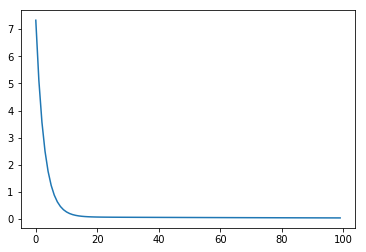

In [24]:
plt.plot(loss_vals)

In [25]:
print(sess.run(y_pred))

[[-0.34226897]
 [-1.1658527 ]
 [-1.9894365 ]
 [-2.8130202 ]]


In [26]:
print(sess.run(y_true))

[[ 0.]
 [-1.]
 [-2.]
 [-3.]]


In [27]:
tf.reset_default_graph()

# Basic image classification example

In [28]:
from tensorflow import keras

In [29]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [30]:
train_images.shape

(60000, 28, 28)

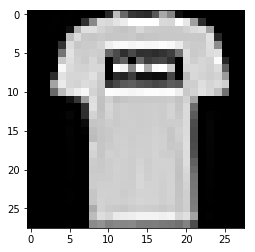

In [31]:
plt.imshow(train_images[1], cmap='gray')

In [32]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [33]:
df = pd.DataFrame()
df['Label'] = np.sort(np.unique(train_labels))
df['Class'] = class_names
df

,Label,Class
0,0,T-shirt/top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


In [34]:
# scale images
train_images = train_images / 255.0

test_images = test_images / 255.0

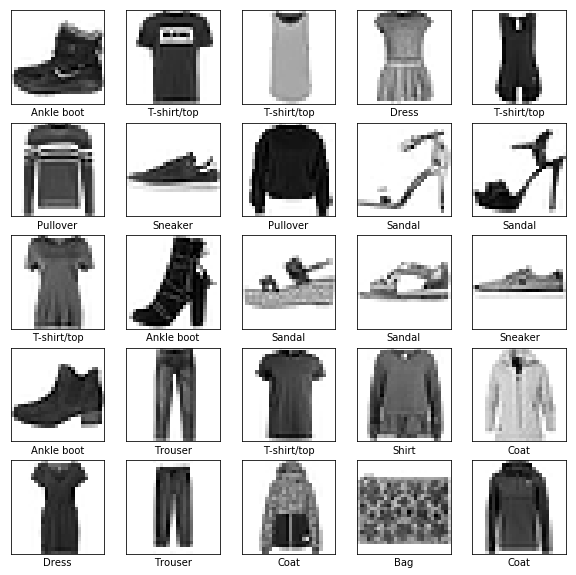

In [35]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


### Build the model 

In [36]:
# set up the layers 

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [37]:
# compile the model 
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.5009 - acc: 0.8245
Epoch 2/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.3737 - acc: 0.8651
Epoch 3/5
60000/60000 [==============================] - 5s 79us/sample - loss: 0.3369 - acc: 0.8774
Epoch 4/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.3119 - acc: 0.8856
Epoch 5/5
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2950 - acc: 0.8899


## make predictions

In [39]:
predictions = model.predict(test_images)

In [40]:
predictions[0]

array([5.0103213e-06, 4.0761019e-08, 1.6798992e-07, 7.7560159e-08,
       4.2749623e-08, 2.1395199e-02, 1.8464491e-06, 2.2050854e-02,
       1.3566538e-05, 9.5653325e-01], dtype=float32)

In [41]:
np.argmax(predictions[0]) == test_labels[0]

True

In [42]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

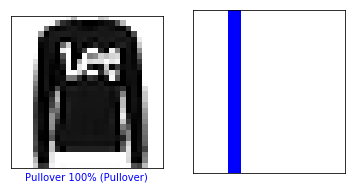

In [43]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()


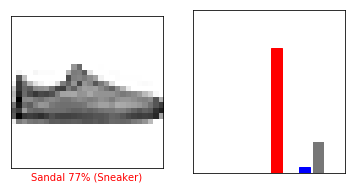

In [44]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

In [45]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
In [ ]:

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()


SyntaxError: invalid syntax (<ipython-input-45-23d748c97594>, line 4)

# Explicitly placing operations on GPU versus CPU

In [ ]:
import time

# Forcing CPU computation: 

n_loops = 2

start = time.time()
for _ in range(n_loops):
    with tf.Session() as sess:
        with tf.device('/cpu:0'): # swap for 'cpu:0' or whatever
            a = tf.random_uniform([1000, 1000], name='a')
            b = tf.random_uniform([1000, 1000], name='b')            
            c = tf.matmul(a, b)
            d = tf.matmul(a, c)
            for _ in range(1000):
                sess.run(d)
end = time.time()
print('CPU: ')
print("{} loops: {:0.2f}s".format(n_loops, end - start))


In [ ]:
# Forcing GPU computation: 

start = time.time()
for _ in range(n_loops):
    with tf.Session() as sess:
        
        with tf.device('/gpu:0'): # swap for 'cpu:0' or whatever
            a = tf.random_uniform([1000, 1000], name='a')
            b = tf.random_uniform([1000, 1000], name='b')            
            c = tf.matmul(a, b)
            d = tf.matmul(a, c)
            for _ in range(1000):
                sess.run(d)
end = time.time()

print('GPU: ')
print("{} loops: {:0.2f}s".format(n_loops, end - start))



# Tensorflow Debugger

Debugging tensorflow code isn't as straightforward as just setting breakpoints, because the computations are only executed when we run a session. 

The tensorflow debugger `tfdbg` is a specialised debugger for tensorflow.

Example from tensorflow website:
https://www.tensorflow.org/guide/debugger

Run in terminal: 

```
python ~/Projects/tensorflow-tutorial/debug_mnist.py 
```

```
Accuracy at step 0: 0.1113
Accuracy at step 1: 0.306
Accuracy at step 2: 0.098
Accuracy at step 3: 0.098
Accuracy at step 4: 0.098
Accuracy at step 5: 0.098
Accuracy at step 6: 0.098
Accuracy at step 7: 0.098
Accuracy at step 8: 0.098
Accuracy at step 9: 0.098
```

The accuracy goes down and gets stuck at chance level. 

Sometimes, this happens because sme nodes output bad numeric values such as infs and nans. To investigate this, we can activate tfdb CLI (command line interface) by wrappin the Session object with a debugger wrapper:

```

from tensorflow.python import debug as tf_debug

sess = tf_debug.LocalCLIDebugWrapperSession(sess)

```

This wrapper allows us to bring up a CLI before and after each `Session.run()` call, so that we can control the execution (like a break point) and inspect the states of nodes in the graph. 
It also allows you to make and use special filters for tensor values, to facilitate the diagnosis of issues. 

We're know going to use an inbuilt filter called `tfdbg.has_inf_or_nan` to check for nans and infs. 

Run in terminal

```
python ~/Projects/tensorflow-tutorial/debug_mnist.py --debug
```

To find infs and nans (the command lt means list dumped tensors):

```
run -f has_inf_or_nan
```

View the value of the tensor:
```
tfdbg> pt cross_entropy/Log:0
```


Get a numeric summary:
```
tfdbg> pt --numeric_summary cross_entropy/Log:0
```

Why did these minus infinities appear? To further debug, we can display `node_info` using the `ni` command:

```
tfdbg> ni cross_entropy/Log
```

From which we see that the node is of type `Log` and that its input is the `Softmax` node. Next, we can look at the input tensor: 

```
tfdbg> pt Softmax:0
```

We can examine the values in the input tensor: searching for zeros:
```
tfdbg> /0\.000
```

Given that there are indeed zeros, we now know that the origin of the bad numerical valuees is that the node `cross_entropy/Log` takes logs of zeros. We can find the corresponding line in the Python file, using the `-t` flag of the `ni` command to show the traceback of the node's construction:

```
tfdbg> ni -t cross_entropy/Log
```

## Fixing the problem:

To fix the problem, we change the line: 

```
diff = -(y_ * tf.log(y))
```

to the built in numerically stable implimentation of softmax cross entropy:
```
diff = tf.losses.softmax_cross_entropy(labels=y_, logits=logits)
```

And then we can rerun the python script to see if the problem persists